### ADVANCED

# Using `tf.keras` for classification tasks
 
#### This notebook builds on [Intro_to_image_classification.ipynb](./Intro_to_image_classification.ipynb) &mdash; you should start there. 

----

This notebook introduces the `keras` API included in `tensorflow` to build artificial neural networks. Tensorflow is one of the most popular libraries to create ML models using neural networks. One of its main advantages is the large community that has formed around it, so it's easy to find multiple tutorials, books and resources to use as reference. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import datetime
import os

## Using `keras.preprocessing`

In [6]:
data_dir = "../data/fossils/raw/"

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = dict(rotation_range=0.2,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    validation_split=0.2,
                    preprocessing_function=lambda img: img / 255,
                    )

train_datagen = ImageDataGenerator(**augmentation)

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(28,28),
                                                    color_mode='grayscale',
                                                    batch_size=4,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

val_generator = train_datagen.flow_from_directory(data_dir,
                                                  target_size=(28,28),
                                                  color_mode='grayscale',
                                                  batch_size=4,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='validation')



Found 252 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


In [14]:
import tensorflow as tf

def create_model(input_shape, n_classes):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Dense(n_classes))
    model.add(tf.keras.layers.Activation('softmax'))
    
    optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

    return model

In [15]:
model = create_model(input_shape=train_generator.image_shape,
                     n_classes=len(train_generator.class_indices))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)         

In [20]:
model_name = 'fossilnet'

model.fit(train_generator,
          validation_data=val_generator,
          validation_freq=1,
          epochs=20,
          verbose=1
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 15 steps
Epoch 1/20
63/63 [==============================] - 3s 41ms/step - loss: 1.2652 - accuracy: 0.4127
Epoch 2/20
63/63 [==============================] - 4s 63ms/step - loss: 1.2651 - accuracy: 0.4286
Epoch 3/20
63/63 [==============================] - 5s 73ms/step - loss: 1.2143 - accuracy: 0.4524
Epoch 4/20
63/63 [==============================] - 4s 57ms/step - loss: 1.1705 - accuracy: 0.4325
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 1.2297 - accuracy: 0.4603 - val_loss: 1.0576 - val_accuracy: 0.5667
Epoch 6/20
63/63 [==============================] - 5s 76ms/step - loss: 1.2581 - accuracy: 0.3849
Epoch 7/20
63/63 [==============================] - 5s 78ms/step - loss: 1.1229 - accuracy: 0.4762
Epoch 8/20
63/63 [==============================] - 4s 66ms/step - loss: 1.2547 - accuracy: 0.4206
Epoch 9/20
63/63 [==============================] - 4s 67ms/step - loss: 1

## Model evaluation

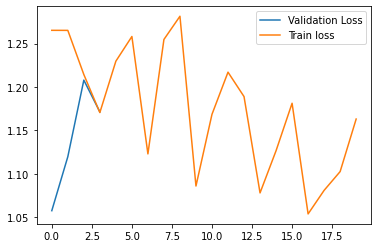

In [21]:
hist = model.history.history
plt.plot(hist['val_loss'], label='Validation Loss')
plt.plot(hist['loss'], label='Train loss')
plt.legend()

## Custom callbacks

We can create and track any number/metric or image we want during training using `Tensorboard`. We'll make a custom training callback that will render a confusion matrix image and log it to be displayed in `Tensorboard` after each epoch is finished. It's not one line of code but once the setup is made, it can be replicated to create other callbacks.

In [23]:
from sklearn.metrics import confusion_matrix
import itertools
import io

curr_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(
    "fossil_logs",
    "fit",
    curr_date,
)

imlogdir = os.path.join(log_dir, "plots")
file_writer = tf.summary.create_file_writer(imlogdir)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    return tf.expand_dims(image, 0)

Now the actual custom callback object. If you're not familiar with Python classes, what we're doing is creating a special version of `tf.keras.callbacks.Callback` (the so-called 'base class') and slightly changing its features. 

In [16]:
class CMCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, val_data, log_dir, batch_size=50):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        self.cmwrite = tf.summary.create_file_writer(log_dir + '/cm')
        #!--
        # more writers for other metrics?
        #--!
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total))
        val_true = np.zeros((total))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            
            val_pred = np.argmax(np.asarray(self.model.predict(xVal)), axis=1)
            val_true = np.argmax(yVal, axis=1)
        
        class_names = list(self.validation_data.class_indices.keys())
        val_pred = np.squeeze(val_pred)
        
        # Calculate the confusion matrix.
        cm = sklearn.metrics.confusion_matrix(val_true, val_pred)
        # Log the confusion matrix as an image summary.
        figure = plot_confusion_matrix(, X_val, y_val)
        cm_image = plot_to_image(figure)

        # Log the confusion matrix as an image summary.
        with self.cmwrite.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
            #!--
#         _val_f1 = f1_score(val_true, val_pred)
#         _val_precision = precision_score(val_true, val_pred)
#         _val_recall = recall_score(val_true, val_pred)
        
#         self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
            #--!
        
        return


Enable `Tensorboard` in this notebook

In [19]:
%load_ext tensorboard
%tensorboard --logdir 'path/to/the/logs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20794), started 0:36:54 ago. (Use '!kill 20794' to kill it.)

Train the network

In [20]:
n_class = len(np.unique(train_generator.classes))
model = create_model((32, 32, 1), n_class)

model_name = 'fossil_classifier_v2'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(f'{log_dir}/{model_name}.h5', monitor='val_loss', verbose=1, save_best_only=True)
cm_callback = CMCallback(val_generator, log_dir)


callbacks = [tensorboard_callback, es_callback, checkpoint_callback, cm_callback]


model.fit_generator(train_generator, steps_per_epoch=50, validation_data=val_generator, validation_steps=10, epochs=30, callbacks=callbacks, verbose=0)


Epoch 00001: val_loss improved from inf to 3.54578, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00002: val_loss did not improve from 3.54578

Epoch 00003: val_loss improved from 3.54578 to 2.93455, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00004: val_loss improved from 2.93455 to 1.87211, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00005: val_loss improved from 1.87211 to 1.69905, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00006: val_loss improved from 1.69905 to 1.22887, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00007: val_loss improved from 1.22887 to 1.18501, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00008: val_loss improved from 1.18501 to 1.13126, saving model to fossil_logs/fit/20191025-141904/fossil_classifier_v2.h5

Epoch 00009: val_loss improved from 1.13126 to 1

## All the tracked metrics and loss history are available through methods of the `model` object.

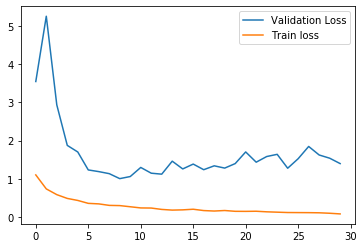

In [23]:
hist = model.history.history
plt.plot(hist['val_loss'], label='Validation Loss')
plt.plot(hist['loss'], label='Train loss')
plt.legend()

In [24]:
y_probs = model.predict(X_val.reshape(-1, 32, 32, 1))

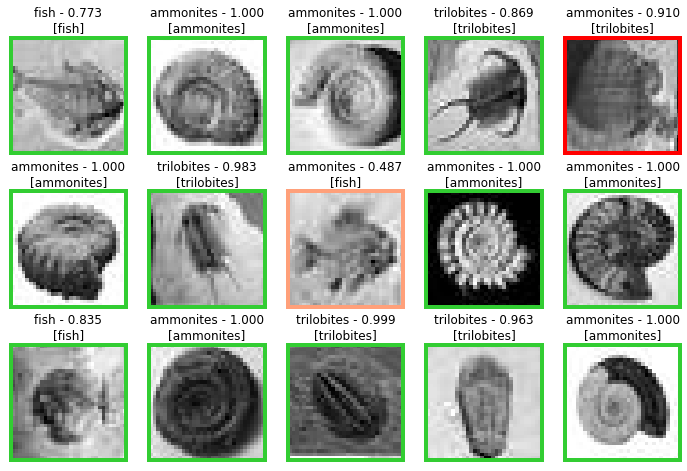

In [25]:
import utils

utils.visualize(X_val, y_val, y_probs, ncols=5, nrows=3, shape=(32, 32))
plt.show()

## Combining `tensorflow.keras` and `sklearn`

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import joblib

In [75]:
num_classes = 3

# input image dimensions
img_rows, img_cols = 32, 32
# input image shape
input_shape = (img_rows, img_cols, 1)
# select a keras optimizer
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

def create_model(input_shape, kernel_size=5, pool_size=2, filters=32, dense_layer_sizes=[[32]]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters*2, kernel_size, padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    
    for layer_size in dense_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size))
        model.add(tf.keras.layers.Activation('elu'))
        model.add(tf.keras.layers.Dropout(0.25))
        
    model.add(tf.keras.layers.Dense(n_class))
    model.add(tf.keras.layers.Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])
    return model


Just as in the `scikit-learn` example, we can make use of `GridSearchCV` to setup a training run that can validate itself. This is just an example of that:

In [78]:
dense_size_candidates = [[32]]

kclf = KerasClassifier(create_model, batch_size=32)
clf = GridSearchCV(kclf,
                   param_grid={'dense_layer_sizes': dense_size_candidates,
                               'epochs': [3],
                               'filters': [8],
                               'kernel_size': [3],
                               'pool_size': [2]},
                   scoring='neg_log_loss', cv=2)

clf.fit(X_train, y_train)

W0828 11:25:12.609278  8708 deprecation.py:323] From C:\Users\dfcas\Anaconda3\envs\geocomp-ml-tf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 264 samples
Epoch 1/3
264/264 [==============================] - 0s 2ms/sample - loss: 1.1431 - accuracy: 0.2311
Epoch 2/3
264/264 [==============================] - 0s 421us/sample - loss: 1.1231 - accuracy: 0.2576
Epoch 3/3
264/264 [==============================] - 0s 402us/sample - loss: 1.1273 - accuracy: 0.2689
Train on 264 samples
Epoch 1/3
264/264 [==============================] - 0s 2ms/sample - loss: 1.0422 - accuracy: 0.4621
Epoch 2/3
264/264 [==============================] - 0s 420us/sample - loss: 1.0673 - accuracy: 0.3864
Epoch 3/3
264/264 [==============================] - 0s 436us/sample - loss: 1.0544 - accuracy: 0.4318
Train on 528 samples
Epoch 1/3
528/528 [==============================] - 0s 852us/sample - loss: 1.1309 - accuracy: 0.3371
Epoch 2/3
528/528 [==============================] - 0s 390us/sample - loss: 1.1323 - accuracy: 0.2955
Epoch 3/3
528/528 [==============================] - 0s 367us/sample - loss: 1.1243 - accuracy: 0.3258


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000266622F34A8>,
             iid='warn', n_jobs=1,
             param_grid={'dense_layer_sizes': [[32]], 'epochs': [3],
                         'filters': [8], 'kernel_size': [3], 'pool_size': [2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

We can quickly look at some of the training metrics from the classification task:

In [80]:
# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = clf.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(X_test, y_test) # included in keras
for metric, value in zip(metric_names, metric_values):
    print(metric, ': ', value)

58/58 [==============================] - 0s 2ms/sample - loss: 1.0997 - accuracy: 0.3621
loss :  1.099675363507764
accuracy :  0.36206895


A couple of thins about predictiong from the `KerasClassifier` and the keras model directly:
- The `scikit-learn` `keras` classifier doesn't return a one hot encoded prediction. It returns the index of class where the probability has a maximum value.
- The `keras` model itself does return the `softmax` output: a 1D vector per image with the probability of each class membership.

In [81]:
clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [82]:
np.array([np.where(r==1)[0][0] for r in y_test])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

### Class probability

The network can emit probabilities. Each instance's vector contains the probability of each class. The argmax of this gives the predicted class.

In our poor result, the classes are almost equally likely.

In [16]:
y_probs = clf.predict_proba(X_val.reshape(-1, 32, 32, 1))
y_probs[:10]

array([[0.38141957, 0.31409907, 0.3044813 ],
       [0.344924  , 0.3376687 , 0.31740737],
       [0.36164916, 0.32597092, 0.31237987],
       [0.44028756, 0.30809033, 0.25162208],
       [0.36222538, 0.33401406, 0.3037606 ],
       [0.3495566 , 0.3458655 , 0.30457795],
       [0.43931577, 0.3164123 , 0.24427192],
       [0.45572835, 0.310084  , 0.23418768],
       [0.34788838, 0.33028018, 0.32183146],
       [0.39261463, 0.3217628 , 0.2856226 ]], dtype=float32)

The `utils` module contains a utility for visualizing the results. The predicted class is shown with the prediction probability; underneath, the actual class is shown in brackets.

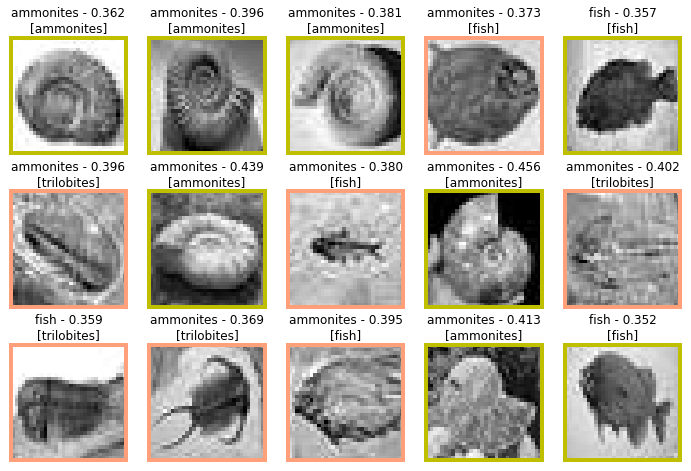

In [24]:
import utils

utils.visualize(X_val, y_val, y_probs, ncols=5, nrows=3, shape=(32, 32))
plt.show()

We can still use the usual `scikit-learn` metrics to check the quality of the model:

In [84]:
from sklearn.metrics import f1_score

f1_score(np.array([np.where(r==1)[0][0] for r in y_test]), clf.predict(X_test), average='weighted')


C:\Users\dfcas\Anaconda3\envs\geocomp-ml-tf2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2118898343036274

The same idea of model persistance applies to `keras` models via `joblib`.

In [93]:
clf.best_estimator_.model.save('fossil_model.h5')

### Cloud power!

Our network doesn't perform very well. Maybe more filters, more layers, or more training will help. Unfortunately, we'll quickly hit the ceiling of performance on our laptops. We need a bigger computer!

Luckily, Google lets us use their computers, and even their GPUs and TPUs, for free in Google Colab.

Here's a TensorFlow CNN running on Google Colab:

### https://ageo.co/evRsvJ

*Remember to change the Runtime to TPU.*

# Transfer Learning application

We'll use `mobilenet` a popular image classification NN architecture to help classify our fossil images we'll use the weights trained by someone else!

In [105]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We'll initialize a `MobileNet` model and we'll remove the last layer. In this way we can append our own last layer and only train that with our fossil images. Note that we're using a different way to "add" or connect layers. We're using the *functional* way of interacting with the Keras API:

In [97]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(4,activation='softmax')(x)

C:\Users\dfcas\Anaconda3\envs\geocomp-ml-tf2\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 3s 0us/step


In [98]:
model=Model(inputs=base_model.input, outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

We can specify how many layers we want to freeze and how many we want the weights to be recalculated.

In [99]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

We can also make use of `keras` included ability to process images for us. This will always save a significant amount of time.

In [100]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator = train_datagen.flow_from_directory('../data/fossils/mobilenet/train/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_generator = train_datagen.flow_from_directory('../data/fossils/mobilenet/val/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=77,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 690 images belonging to 4 classes.
Found 77 images belonging to 4 classes.


Finally, we just need to re-train the network given the setup specified.

In [101]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=val_generator,
                    validation_steps=1,
                    epochs=10)

Epoch 1/10
21/21 [==============================] - 171s 8s/step - loss: 0.5586 - accuracy: 0.8085 - val_loss: 6.1471 - val_accuracy: 0.3377
Epoch 2/10
21/21 [==============================] - 171s 8s/step - loss: 0.2349 - accuracy: 0.9330 - val_loss: 6.8818 - val_accuracy: 0.3766
Epoch 3/10
21/21 [==============================] - 165s 8s/step - loss: 0.1081 - accuracy: 0.9689 - val_loss: 0.3374 - val_accuracy: 0.8961
Epoch 4/10
21/21 [==============================] - 173s 8s/step - loss: 0.0729 - accuracy: 0.9818 - val_loss: 0.3208 - val_accuracy: 0.9221
Epoch 5/10
21/21 [==============================] - 156s 7s/step - loss: 0.0417 - accuracy: 0.9863 - val_loss: 0.9050 - val_accuracy: 0.8312
Epoch 6/10
21/21 [==============================] - 148s 7s/step - loss: 0.0563 - accuracy: 0.9818 - val_loss: 3.0866 - val_accuracy: 0.6364
Epoch 7/10
21/21 [==============================] - 146s 7s/step - loss: 0.1300 - accuracy: 0.9650 - val_loss: 1.3227 - val_accuracy: 0.8182
Epoch 8/10
21

Let's load an image and make a classification using a our model:

In [106]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

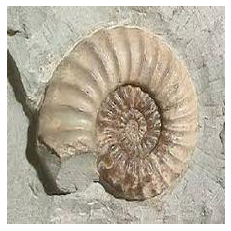

In [107]:
new_image = load_image('../data/fossils/mobilenet/val/ammonites/0076.jpg', True)

In [108]:
np.argmax(model.predict(new_image))

0

In [109]:
val_generator.class_indices

{'ammonites': 0, 'fish': 1, 'plants': 2, 'trilobites': 3}

# What if we just want to use a pre-trained model already trained:

In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
# load the model
model = VGG19()
# load an image from file
image = load_img('../data/fossils/mobilenet/val/ammonites/0076.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print(f'{label[1]} {label[2]*100:.2f}')

40960/35363 [==================================] - 0s 1us/step
chambered_nautilus 91.28
